Library Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import warnings
import pickle
import os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(10)

2022-12-25 04:20:08.495387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 04:20:11.515591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/maarij/anaconda3/envs/tf/lib/
2022-12-25 04:20:11.515925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/maarij/anaconda3/envs/tf/lib/
2022-12-25 04:20:11.515942: W tensorflow/compiler/tf2ten

Print All Files In Data-Set Folder

In [2]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset/test/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.midi
./dataset/maestro_v3/MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--4.midi
./dataset/maestro_v3/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_03_Track03_wav.midi
./dataset/maestro_v3/MIDI-Unprocessed_02_R2_2011_MID--AUDIO_R2-D1_02_Track02_wav.midi
./dataset/maestro_v3/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--3.midi
./dataset/maestro_v3/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--4.midi
./dataset/maestro_v3/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--3.midi
./dataset/maestro_v3/MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--4.midi
./dataset/maestro_v3/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--5.midi
./dataset/maestro_v3/MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_14_Track14_wav.midi
./dataset/maestro_v3/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.midi
./dat

Test GPU (For TensorFlow Usage)

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


2022-12-25 04:20:17.747920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 04:20:18.352822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-25 04:20:18.423284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-25 04:20:18.423383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Read All MIDI Files And Create/Pickle Note Stream

In [5]:
# load midis as stream
filepath = "./dataset/test/"

#Getting midi files
notes = []
count = 0
for i in os.listdir(filepath):
    if i.endswith(".midi"):
        count += 1
        print(count, i)
        tr = filepath+i

        # read midi file
        midi = converter.parse(tr)

        # parse file into notes / chords - chords are made of multiple notes
        songs = instrument.partitionByInstrument(midi)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Rest) and element.offset != 0:
                    strAppend = 'R' + str(element.duration.quarterLength)
                    notes.append(strAppend)
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

# pickle file
pikFile = open('./notes.pickle', 'wb')
pickle.dump(notes, pikFile)
pikFile.close()

1 MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.midi


Read Notes From Pickle File

In [18]:
pikFile = open('./notes.pickle', 'rb')
notesCorpus = pickle.load(pikFile)
pikFile.close()

len(notesCorpus)
print(notesCorpus)

[[]]


Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmp987apxh9.ly'
Parsing...
Interpreting music...[8][16][24][32][40][48]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmp987apxh9.ly.eps'...
Converting to PNG...
Layout output to `tmp987apxh9.ly-1.eps'...
Layout output to `tmp987apxh9.ly-2.eps'...
Layout output to `tmp987apxh9.ly-3.eps'...
Layout output to `tmp987apxh9.ly-4.eps'...
Layout output to `tmp987apxh9.ly-5.eps'...
Layout output to `tmp987apxh9.ly-6.eps'...
Layout output to `tmp987apxh9.ly-7.eps'...
Layout output to `tmp987apxh9.ly-8.eps'...
Layout output to `tmp987apxh9.ly-9.eps'...
Layout output to `tmp987apxh9.ly-10.eps'...
Layout output to `tmp987apxh9.ly-11.eps'...
Layout output to `tmp987apxh9.ly-12.eps'...
Layout output to `tmp987apxh9.ly-13.eps'...
Layout output to `tmp987apxh9.ly-14.eps'...
Layout output to `tmp987apxh9.ly-15.eps'...
Layout output to `tmp987apxh9.ly-16.eps'...
Layout output to 

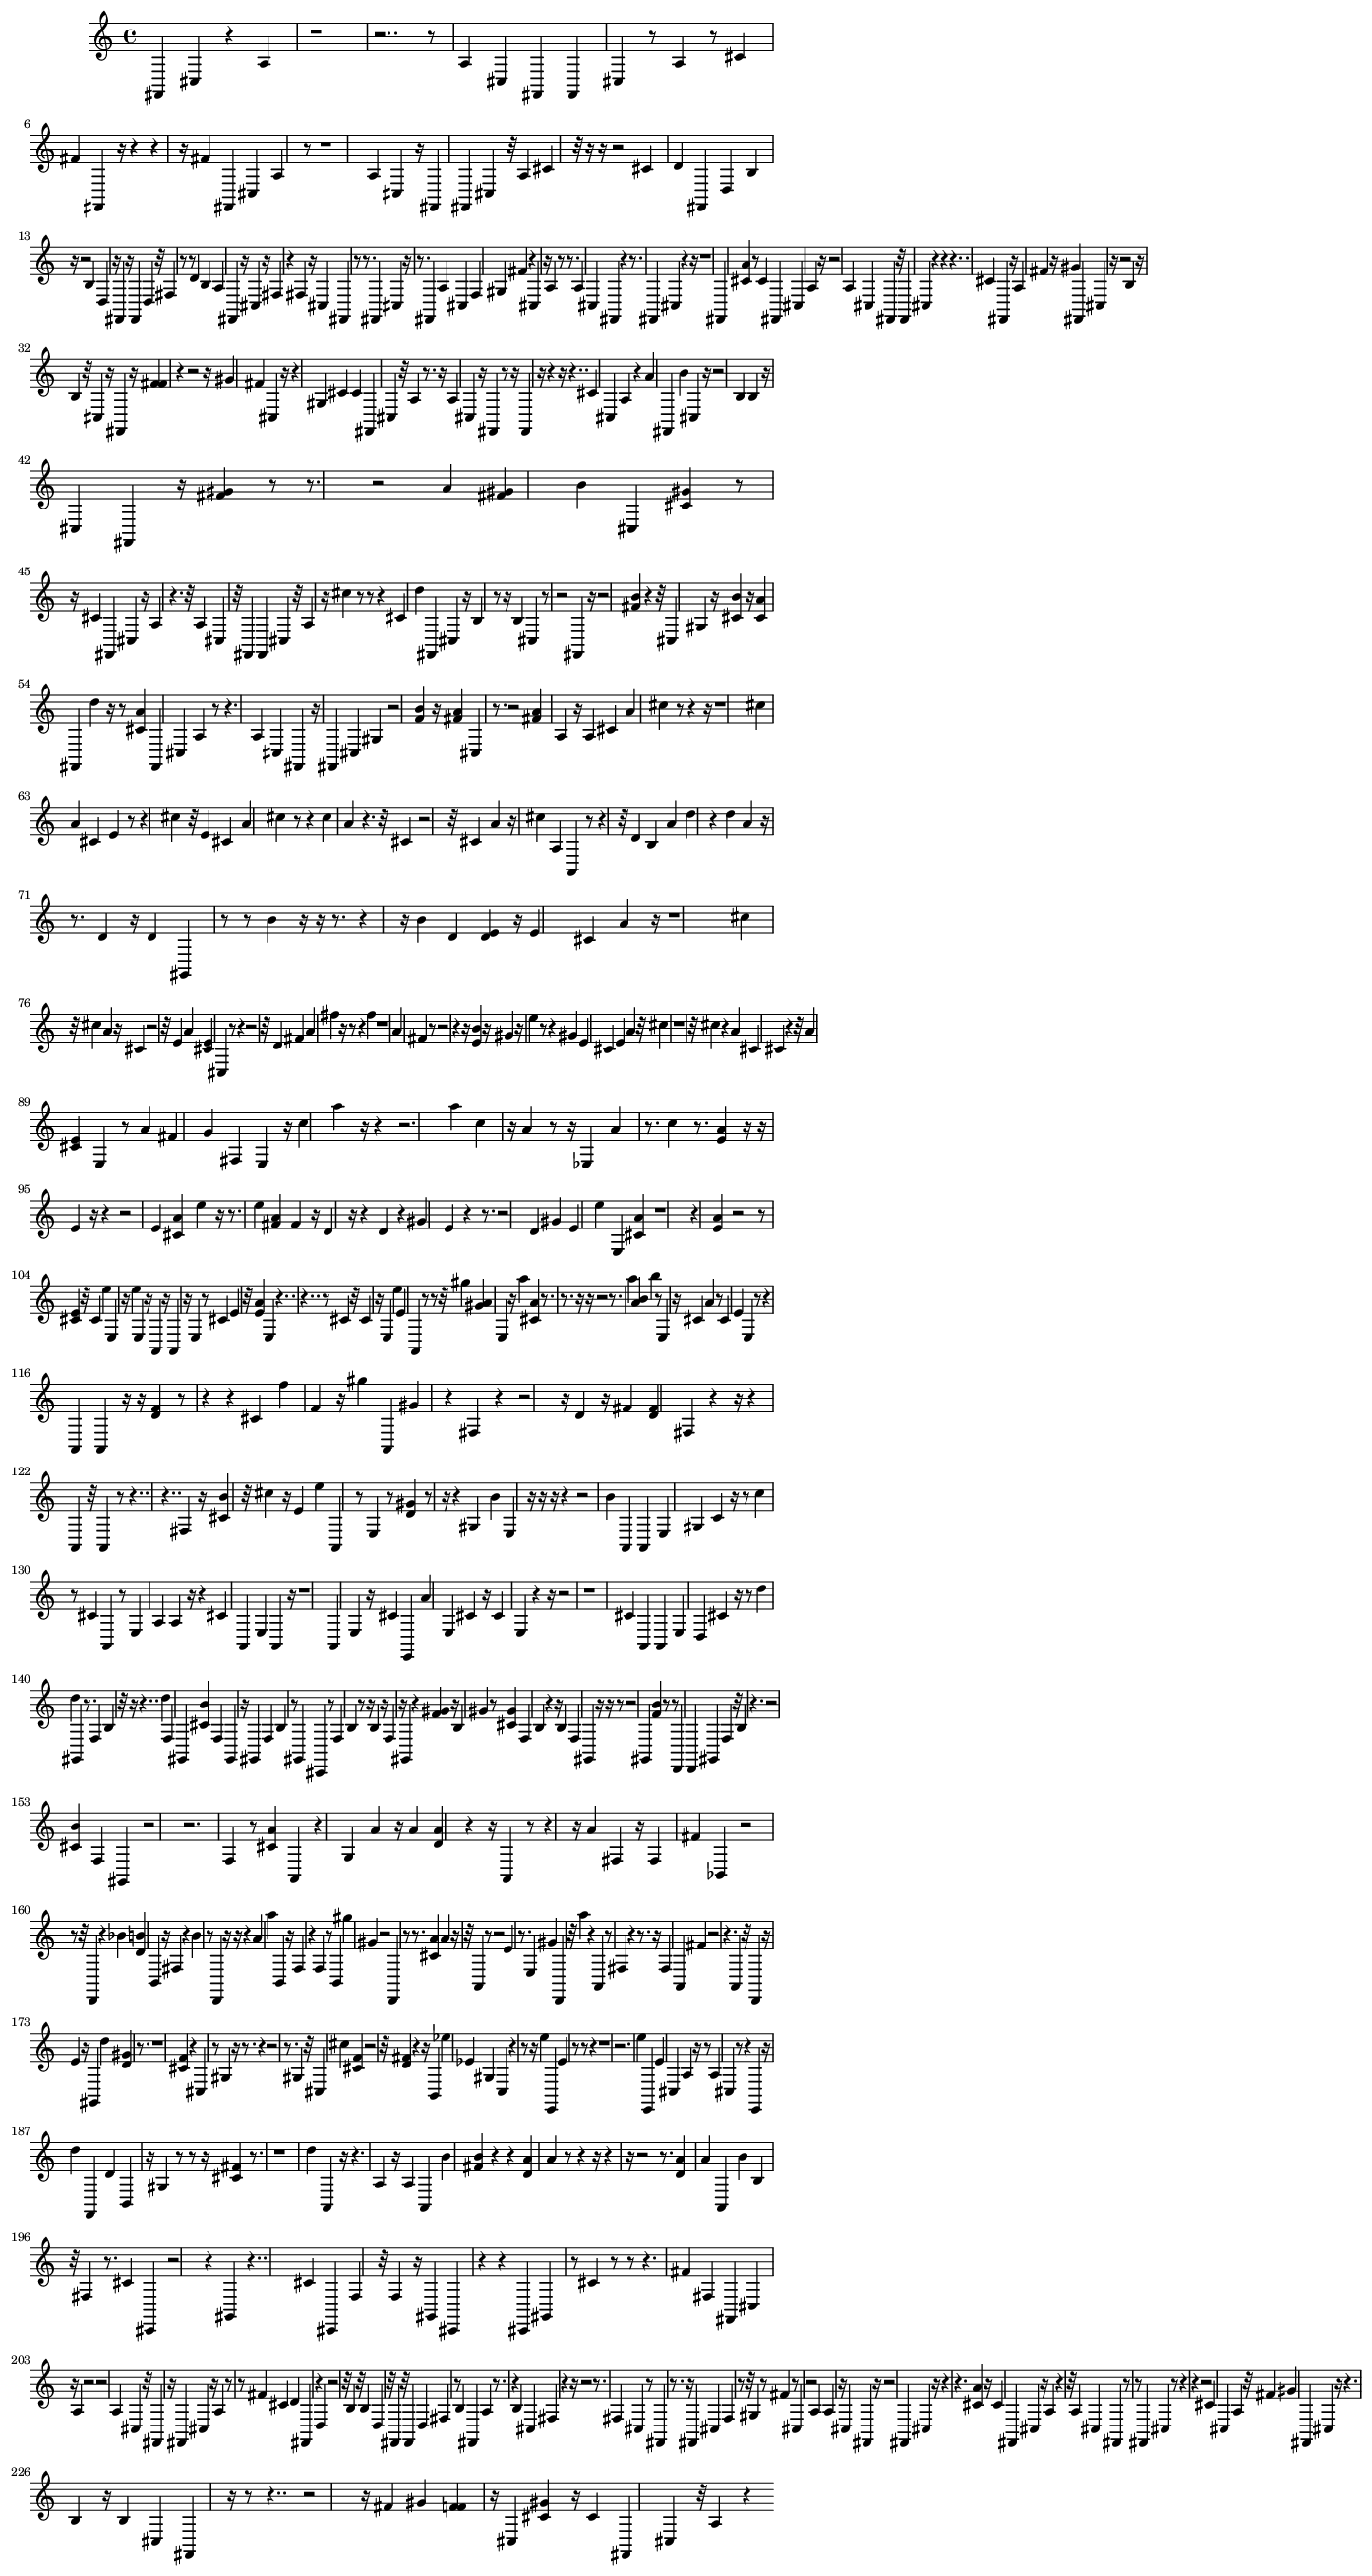

'test.midi'

In [73]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        # if rest
        if (i[0] == 'R'):
            i = i.lstrip('R')
            rst = note.Rest(quarterLength=eval(i))
            rst.offset = offset
            Melody.append(rst)
        
        #If it is chord
        elif ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            Melody.append(chord_snip)
            
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 0
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(notesCorpus[:1000])
show(Melody_Snippet)
#To save the generated melody
Melody_Snippet.write('midi','test.midi')